In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

# our own code
from sde.sde_learning_network import SDEIntegrators
from sde.experiment_reports import *
from gillespie.sir import SIRG

In [34]:
N_iterates = 1000
t_end = 5
step_size = 1e-2

# SIR model paramters
k1,k2 = 1,1
N = 400
sirg = SIRG(N=N, k1=k1, k2=k2, k3=0)

# define the initial condition
init_theta0 = 0.98
init_theta1 = 0.02
init_theta2 = 1-(init_theta0+init_theta1)
initial_condition = np.array([init_theta0, init_theta2]).reshape(1,-1)

random_state = 1

In [35]:
# define methods
def theta02(traj):
    """
    Convert theta12 data to theta02 data (theta0 has "more interesting" trajectories)
    """
    traj_new = traj.copy()
    traj_new[:,0] = 1-(traj[:,0]+traj[:,1])
    return traj_new

def true_drift(x):
    """
    drift for theta 0 and 2.
    """
    theta0 = np.clip(x[:,0], 0, 1)
    theta2 = np.clip(x[:,1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    return np.stack([-r1, r2], axis=1)

def true_diffusivity(x):
    """
    Note that the diffusivity here includes _no_ off-diagonal terms!
    So we can just use the diagonal version of the codes.
    """
    theta0 = np.clip(x[:,0], 0, 1)
    theta2 = np.clip(x[:,1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    return np.stack([np.sqrt(r1/N), np.sqrt(r2/N)], axis=1)

def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)

def gen_results_t(step_size, T_steps, N_iterates):
    """
    Wrapper function so that we do not need to pass all these parameters to "probability_density".
    """
    return generate_results(true_drift_diffusivity,
                        step_size, initial_condition,
                        rng, T_steps = T_steps, N_iterates=N_iterates)

def gen_results_g(step_size, T_steps, N_iterates):
    """
    Wrapper function so that we do not need to pass all these parameters to "probability_density".
    """
    time_max_test = T_steps * step_size
    step_size_gillespie = step_size
    
    y0 = np.ones((N_iterates,1)) @ initial_condition.reshape(1,-1)
        
    # gillespie needs (theta1,theta2) input
    time_steps, y = sirg.simulate(theta02(y0), time_max = time_max_test, time_step=step_size_gillespie)

    # transform to (theta0,theta2) so that all paths (network, SDE, Gillespie) are in terms of (t0,t2)
    path_gillespie = [theta02(y[k]) for k in range(len(y))]
    
    return time_steps, path_gillespie

In [36]:
# simulate
rng = np.random.default_rng(random_state)

t0 = time()
pt, time_steps_t, paths_t = probability_density(t=t_end, _generate_results=gen_results_t,
                             step_size=step_size, rng=rng, N_iterates=N_iterates)
print(f"sampling SDE took {time()-t0} seconds.")

t0 = time()
pg, time_steps_g, paths_g = probability_density(t=t_end, _generate_results=gen_results_g,
                             step_size=step_size, rng=rng, N_iterates=N_iterates)
print(f"sampling Gillespie took {time()-t0} seconds.")

sampling SDE took 93.95994782447815 seconds.
sampling Gillespie took 0.09873509407043457 seconds.


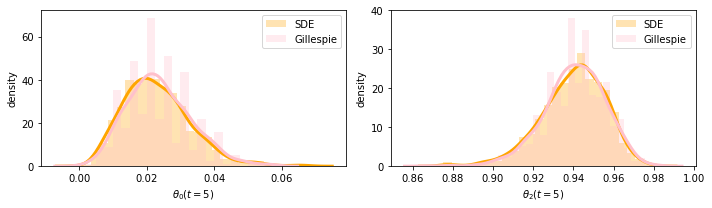

In [39]:

bins = np.linspace(0, 1, 100)
fig,ax = plt.subplots(1,2,figsize=(10,3))

t1 = pd.DataFrame(pt[:,0], columns=["true 1"])
t2 = pd.DataFrame(pt[:,1], columns=["true 2"])

g1 = pd.DataFrame(pg[:,0], columns=["gillespie 1"])
g2 = pd.DataFrame(pg[:,1], columns=["gillespie 2"])

kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':3})

sns.distplot(t1,ax=ax[0], color="orange", label="SDE", **kwargs);
sns.distplot(t2,ax=ax[1], color="orange", label="SDE", **kwargs);
sns.distplot(g1,ax=ax[0], color="pink", label="Gillespie", **kwargs);
sns.distplot(g2,ax=ax[1], color="pink", label="Gillespie", **kwargs);
ax[0].set_xlabel(r"$\theta_0(t="+str(t_end)+")$")
ax[0].set_ylabel("density")
ax[0].legend();
ax[1].set_xlabel(r"$\theta_2(t="+str(t_end)+")$")
ax[1].set_ylabel("density")
ax[1].legend();
#ax[0].set_ylim([0,5])
#ax[1].set_ylim([0,5])

#ax[0].set_xlim([0,1])
#ax[1].set_xlim([0,1])

fig.tight_layout()

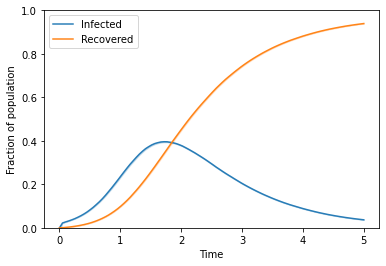

In [40]:
paths_g_sampled = []
time_sample = np.linspace(0, t_end, 100)

for k in range(len(time_steps_g)):
    _newpath = np.column_stack([
        scipy.interpolate.interp1d(time_steps_g[k], paths_g[k][:,i],
                                   fill_value="extrapolate",
                                   kind="linear")(time_sample)
        for i in range(paths_g[0].shape[1])
    ])
    paths_g_sampled.append(_newpath)
    
data = [
    np.column_stack([time_sample, theta02(paths_g_sampled[k])])
    for k in range(len(paths_g_sampled))
]

df = pd.DataFrame(np.row_stack(data), columns=["time", "t0", "t1"])
ax = sns.lineplot(x="time", y="t0", err_style="band", data=df, alpha=0.95, label='Infected')
ax = sns.lineplot(x="time", y="t1", err_style="band", data=df, alpha=0.95, label="Recovered")

ax.set(xlabel="Time", ylabel="Fraction of population")
ax.set_ylim([0,1])
ax.legend();